# Three-compartment model

<img src="./ToyReactor2.png"/ width="500">

Three compartments:
* Gas (g)
* Liquid (l)
* Cell (c)

## Variables

* $u$: volumetric flow rate; $\displaystyle [u]=\frac{L}{h}$
* $c$: input concentration of $X$; $\displaystyle [c]=\frac{mmol}{L}$
* $X$ and $Y$: amount; $[X]=[Y]=mmol$ 
* $x$ and $y$: concentration; $\displaystyle [x]=[y]=\frac{mmol}{L}$
* $V$: volume; $[V]=L$
* $v$: reaction rate; $\displaystyle [v]=\frac{mmol}{h}$
* $J$: transport rate; $\displaystyle [J]=\frac{mmol}{h}$
* $Q$: equlibrium constant; dimension-less
* $A$: area; $[A]=m^2$

### Some realtionships between variables
* $V_c \propto Z$ (proportionality constant assumed known)
* $A_c \propto V_c^{\frac{2}{3}} \propto Z^{\frac{2}{3}}$

## Rate equations:

1. Flow rate of $X$ into gas: $\displaystyle J_{T_{x,in}}= u c$

2. Transport rate of $X$ from gas to liquid: $\displaystyle J_{T_{x,gl}} = k_{T_{x,gl}} A_l \left( x_g - \frac{x_l}{Q_{T_{x,gl}}} \right) \approx k'_{T_{x,gl}} u \left( \frac{X_g}{V_g} - \frac{X_l}{V_l}\frac{1}{Q_{T_{x,gl}}} \right)$ 

3. Transport rate of $X$ from liquid to cell: $\displaystyle J_{T_{x,lc}} = k_{T_{x,lc}} A_c \left(x_l - \frac{x_c}{Q_{T_{x,lc}}} \right) = k'_{T_{x,lc}} Z^{\frac{2}{3}} \left(\frac{X_l}{V_l} - \frac{X_c}{V_c}\frac{1}{Q_{T_{x,lc}}} \right) = k'_{T_{x,lc}} Z^{\frac{2}{3}} \left(\frac{X_l}{V_l} - \frac{X_c}{Z}\frac{1}{Q'_{T_{x,lc}}} \right)$

4. Reaction rate of $X \leftrightarrow Y$: $\displaystyle v_{R_{xy}} = k_{R_{xy}} Z \left( x_c - \frac{y_c}{Q_{R_{xy}}} \right) = k_{R_{xy}} Z \left( \frac{X_c}{V_c} - \frac{Y_c}{V_c}\frac{1}{Q_{R_{xy}}} \right) = k'_{R_{xy}} \left( X_c - \frac{Y_c}{Q_{R_{xy}}} \right)$

5. Reaction rate of $X \rightarrow Z$: $\displaystyle v_{R_{xz}} = k_{R_{xz}} Z x_c \left(1 - \frac{Z}{Z_{max}}\right) = k_{R_{xz}} Z \frac{X_c}{V_c} = k'_{R_{xz}} X_c \left(1 - \frac{Z}{Z_{max}}\right)$

6. Transport rate of $Y$ from cell to liquid: $\displaystyle J_{T_{y,cl}}=k_{T_{y,cl}} A_c \left( y_c - \frac{y_l}{Q_{T_{y,cl}}}\right) = k'_{T_{y,cl}} Z^{\frac{2}{3}} \left( \frac{Y_c}{V_c} - \frac{Y_l}{V_l}\frac{1}{Q_{T_{y,cl}}}\right) = k''_{T_{y,cl}} Z^{\frac{2}{3}} \left( \frac{Y_c}{Z} - \frac{Y_l}{V_l}\frac{1}{Q'_{T_{y,cl}}}\right)$

7. Transport rate of $Y$ from liquid to gas: $\displaystyle J_{T_{y,lg}} = k_{T_{y,lg}} A_l \left(y_l - \frac{y_g}{Q_{T_{y,lg}}} \right) = k'_{T_{y,lg}} \left(\frac{Y_l}{V_l} - \frac{Y_g}{V_g}\frac{1}{Q_{T_{y,lg}}} \right)$

8. Flow rate of $X$ out of gas: $\displaystyle J_{T_{x,out}} = u x_g = u \frac{X_g}{V_g}$

13. Flow rate of $Y$ out of gas: $\displaystyle J_{T_{y,out}} = u y_g = u \frac{Y_g}{V_g}$

### Notes
* For rate equation #2, we treat $A_l \propto u$ here to model the dependence of $A_l$ on $u$ via bubbling.
* For rate equation #5, logistic growth of biomass is used, otherwise $Z$ will grow indefinitely and the system will not settle to steady state.

## Parameters
1. $u$
2. $c$
3. $k'_{T_{x,gl}}$
4. $k'_{T_{x,lc}}$
5. $k'_{R_{xy}}$
6. $k'_{R_{xz}}$
7. $k''_{T_{y,cl}}$
8. $k'_{T_{y,lg}}$
9. $Z_{max}$

In [1]:
# build the model

from __future__ import absolute_import, division, print_function

import numpy as np

from rxnnet import network, experiments, mca
from infotopo import residual, fitting, sampling

In [3]:
reactor = network.Network('reactor')

reactor.add_compartment('liquid', 1)
reactor.add_compartment('gas', 1)
reactor.add_compartment('cell', 1)

reactor.add_species('Xl', 'liquid', 0)
reactor.add_species('Xc', 'cell', 0)
reactor.add_species('Xg', 'gas', 0)
reactor.add_species('Yl', 'liquid', 0)
reactor.add_species('Yc', 'cell', 0)
reactor.add_species('Yg', 'gas', 0)
reactor.add_species('Z', 'cell', 1)

reactor.add_parameter('Vl', 10, is_optimizable=False)
reactor.add_parameter('Vg', 1, is_optimizable=False)

for rxnid in ['Txgl', 'Txlc', 'Tycl', 'Tylg', 'Rxy']:
    reactor.add_parameter('KE_%s'%rxnid, 1, is_optimizable=False)

reactor.add_parameter('u', 1, is_optimizable=True)
reactor.add_parameter('c', 1, is_optimizable=True)
for rxnid in ['Txgl', 'Txlc', 'Rxy', 'Rxz', 'Tycl', 'Tylg']:
    reactor.add_parameter('kf_%s'%rxnid, 1, is_optimizable=True)
reactor.add_parameter('Zmax', 10, is_optimizable=True)

reactor.add_reaction('Txin', eqn='->Xg', ratelaw='u*c')
reactor.add_reaction('Txgl', eqn='Xg<->Xl', ratelaw='kf_Txgl * u * (Xg/Vg - Xl/Vl/KE_Txgl)')
reactor.add_reaction('Txlc', eqn='Xl<->Xc', ratelaw='kf_Txlc * Z**(2/3) * (Xl/Vl - Xc/Z/KE_Txlc)')
reactor.add_reaction('Rxy', eqn='Xc<->Yc', ratelaw='kf_Rxy * (Xc - Yc/KE_Rxy)')
reactor.add_reaction('Rxz', eqn='Xc<->Z', ratelaw='kf_Rxz * Xc * (1- Z/Zmax)')
reactor.add_reaction('Tycl', eqn='Yc<->Yl', ratelaw='kf_Tycl * Z**(2/3) * (Yc/Z - Yl/Vl/KE_Tycl)')
reactor.add_reaction('Tylg', eqn='Yl<->Yg', ratelaw='kf_Tylg * u * (Yl/Vl - Yg/Vg/KE_Tylg)')
reactor.add_reaction('Txout', eqn='Xg->', ratelaw='u*Xg/Vg')
reactor.add_reaction('Tyout', eqn='Yg->', ratelaw='u*Yg/Vg')

reactor.add_ratevars()
reactor.compile()

In [4]:
print(reactor.xids)
print(reactor.rxnids)
print(reactor.pids)

['Xl', 'Xc', 'Xg', 'Yl', 'Yc', 'Yg', 'Z']
['Txin', 'Txgl', 'Txlc', 'Rxy', 'Rxz', 'Tycl', 'Tylg', 'Txout', 'Tyout']
['u', 'c', 'kf_Txgl', 'kf_Txlc', 'kf_Rxy', 'kf_Rxz', 'kf_Tycl', 'kf_Tylg', 'Zmax']


In [5]:
# integrate to get the time course

traj = reactor.get_traj((0,500))

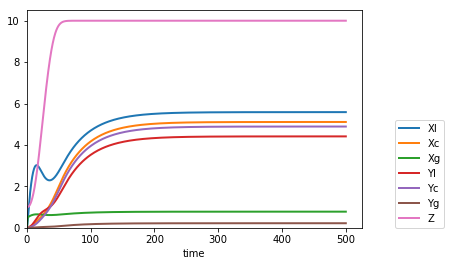

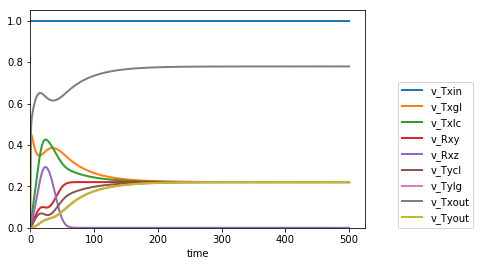

In [6]:
traj.plot(varids=reactor.xids, legendloc=(1.1,0))

traj.plot(varids=reactor.vids, legendloc=(1.1,0))

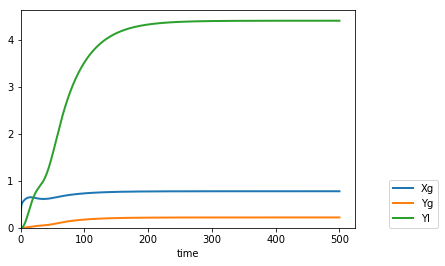

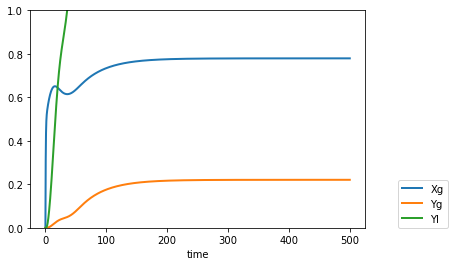

In [7]:
# plotting the trajectories of three variables (Xg, Yg, Yl) which we assume we can measure

datvarids = ['Xg', 'Yg', 'Yl']
traj.plot(varids=datvarids, legendloc=(1.1,0))
traj.plot(varids=datvarids, xylims=[None, [0,1]], legendloc=(1.1,0))

In [8]:
expts = experiments.Experiments()
expts.add_experiment(None, datvarids, np.linspace(0,200,101))

expts

,condition,varids,times
experiment,,,
1,None,"[Xg, Yg, Yl]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."


In [9]:
pred = reactor.get_predict(expts)

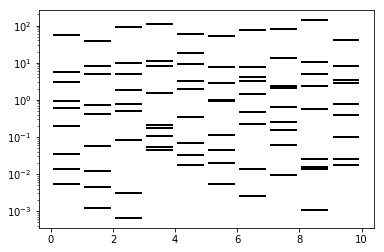

In [10]:
# inspecting the spectrum (list of singular values of the Jacobian) to see if the function is well-behaved (yes)

pred.plot_spectra(ps=[pred.p0.randomize(seed=i) for i in range(10)], figsize=(6,4))

## Generate simulation data and use them for fitting

In [11]:
dat = pred.get_dat()

dat

,Y,sigma
"None, Xg, 0.0",0.000000,1.0
"None, Xg, 2.0",0.514710,1.0
"None, Xg, 4.0",0.561191,1.0
"None, Xg, 6.0",0.592145,1.0
"None, Xg, 8.0",0.615826,1.0
"None, Xg, 10.0",0.632907,1.0
"None, Xg, 12.0",0.643948,1.0
"None, Xg, 14.0",0.649655,1.0
"None, Xg, 16.0",0.650928,1.0
"None, Xg, 18.0",0.648832,1.0


In [12]:
res = residual.Residual(pred, dat)

In [13]:
# confirm that fitting recovers the parameters used for generating the simulated data

fit = fitting.fit_lm_scipy(res, p0=pred.p0.randomize(seed=3), in_logp=True)

print(fit.cost, '\n')
print(fit.p - pred.p0)

3.36696262548e-28 

u         -5.218048e-15
c          4.440892e-16
kf_Txgl   -4.218847e-15
kf_Txlc    2.264855e-14
kf_Rxy    -6.628031e-14
kf_Rxz    -1.254552e-14
kf_Tycl    2.997602e-14
kf_Tylg    2.220446e-16
Zmax      -1.065814e-14
dtype: float64


## Construct parameter ensemble

Below we construct the parameter ensemble by sampling the (posterior) distribution which captures "how data constrain the model".

In [15]:
ens = sampling.sampling(res, nstep=5000, p0=fit.p, in_logp=True, seed=1, 
                        interval_print_step=1000, stepscale=0.5)

1000
2000
3000
4000
5000


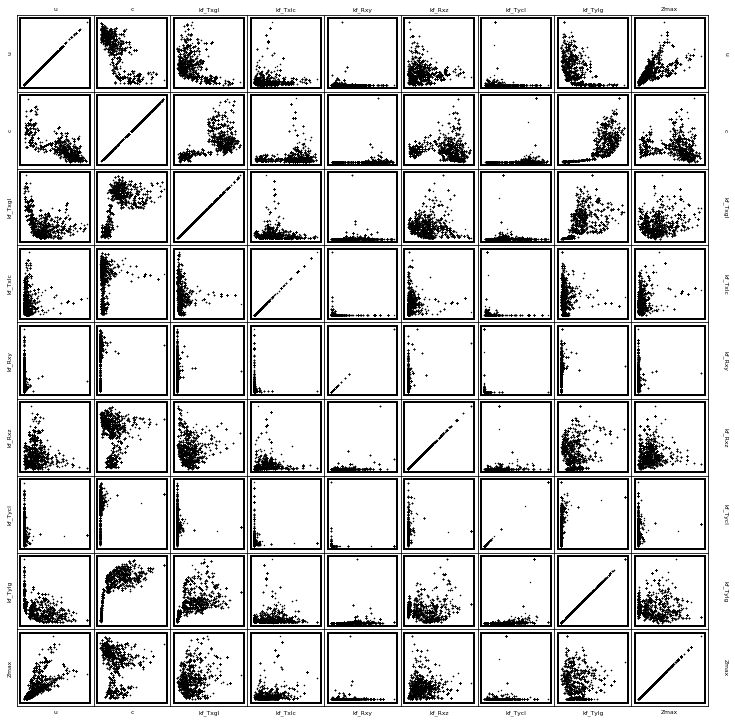

In [16]:
ens.p.scatter(figsize=(12,12))

In [21]:
# get the thinned/decorrelated parameter ensemble

pens = ens.p.iloc[::10]

In [22]:
pens.describe()

,u,c,kf_Txgl,kf_Txlc,kf_Rxy,kf_Rxz,kf_Tycl,kf_Tylg,Zmax
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,0.841109,1.024061,1.580624,1.810114,475.611162,1.021195,19.408758,4.021468,8.751104
std,0.461313,0.196507,0.841520,2.775020,3990.654710,0.629017,163.897781,3.836689,4.325823
min,0.213448,0.676267,0.424507,0.314164,0.110405,0.154526,0.232653,0.110408,1.819985
25%,0.466277,0.789775,0.905508,0.731345,0.789914,0.619225,0.748445,0.380317,5.736048
50%,0.723165,1.105590,1.444329,1.094758,1.919323,0.919878,1.261584,2.864933,7.612013
75%,1.084448,1.181394,1.906769,1.685933,16.359342,1.271829,2.788570,6.852556,11.405430
max,2.675515,1.347755,4.600355,22.876072,81419.264323,5.017487,2526.284991,19.448108,26.242215


## Sensitivity calculation

Next we compute the parameter sensitivity of two quantities:

1. Steady-state concentration of $Y$ in liquid $Y_l$: it is chosen to represent the liquid **titer** of the product. 
2. Steady-state flux of $Y$ in the off-gas $J_{T_{y,out}}$: it is chosen to represent the **productivity** of the product (in the off-gas).

Why are we interested in the parameter sensitivity of these two quantities?

Let's take $Y_l$ as an example. $\displaystyle \frac{\partial Y_l}{\partial p}$ indicates if we change parameter $p$, how responsive is $Y_l$. Since we have nine parameters in this model, we can examine which parameters should be tuned and in what way if we want to increase $Y_l$. 

Such concepts are inspired by **Metabolic Control Analysis** (MCA), and formalize **rate-limiting steps**. For example, if $\displaystyle \frac{\partial J_{T_{Y,out}}}{\partial k_{T_{x,gl}}} \gg 0$ then we may conclude that "the productivity of $Y$ in the off-gas is substrate-transport-limited (from gas to liquid)". 

Plotting the sensitivities over the parameter ensemble constructed above, which results in *histograms* of sensitivities, gives us a sense of how tight the sensitivity predictions are: if our data is able to contrain our model and makes it preditive, sensitivity histograms should have a clear pattern and conveys a clear message.

In [23]:
# Define functions that takes in a parameter vector and computes the parameter sensitivities of 
# select quantities, Yl and JTyout

def get_Yl_sens(p):
    try:
        return mca.get_concentration_response_matrix(reactor, p=p, normed=1).loc['Yl']
    except:
        pass
    
def get_JTyout_sens(p):
    try:
        return mca.get_flux_response_matrix(reactor, p=p, normed=1).loc['Tyout']
    except:
        pass

In [24]:
# Compute the sensivity ensembles (can take a couple of mins depending on ensemble size)

sens_Yl = pens.apply(get_Yl_sens, axis=1)
sens_JTyout = pens.apply(get_JTyout_sens, axis=1)

By inspecting the sensitivity ensembles below, one can see that:
* $\displaystyle \frac{\partial Y_l}{\partial c}$ and $\displaystyle \frac{\partial J_{T_{Y,out}}}{\partial c}$ are always 1
* $\displaystyle \frac{\partial Y_l}{\partial kf_{R_{xz}}}$ and $\displaystyle \frac{\partial J_{T_{Y,out}}}{\partial kf_{R_{xz}}}$ are always 0

This makes sense: the quantities scale linearly with $c$ in our model and reaction $R_{xz}$ always goes to 0 in steady state (all carbon goes to product conversion and none goes to cell growth). 

In [25]:
sens_Yl.describe()

,u,c,kf_Txgl,kf_Txlc,kf_Rxy,kf_Rxz,kf_Tycl,kf_Tylg,Zmax
count,501.000000,5.010000e+02,501.000000,501.000000,5.010000e+02,5.010000e+02,501.000000,501.000000,501.000000
mean,-0.110142,1.000000e+00,0.176309,0.048145,2.028101e-02,3.656924e-19,0.041716,-0.178681,0.080188
std,0.051737,1.801589e-10,0.045852,0.036003,2.950067e-02,1.038243e-17,0.036408,0.102984,0.039334
min,-0.263825,1.000000e+00,0.073899,0.001829,2.460964e-07,-4.982050e-17,0.000016,-0.347658,0.009276
25%,-0.136453,1.000000e+00,0.147047,0.024452,1.519378e-03,0.000000e+00,0.016130,-0.295220,0.053094
50%,-0.103509,1.000000e+00,0.175266,0.036909,1.183742e-02,0.000000e+00,0.034322,-0.156139,0.073516
75%,-0.073056,1.000000e+00,0.206849,0.061586,2.465435e-02,0.000000e+00,0.056932,-0.080413,0.098818
max,-0.013214,1.000000e+00,0.308542,0.188738,1.674451e-01,4.751860e-17,0.200989,-0.029672,0.211287


In [26]:
sens_JTyout.describe()

,u,c,kf_Txgl,kf_Txlc,kf_Rxy,kf_Rxz,kf_Tycl,kf_Tylg,Zmax
count,501.000000,5.010000e+02,501.000000,501.000000,5.010000e+02,5.010000e+02,501.000000,501.000000,501.000000
mean,0.889858,1.000000e+00,0.176309,0.048145,2.028101e-02,3.656924e-19,0.041716,0.202783,0.080188
std,0.051737,1.817843e-10,0.045852,0.036003,2.950067e-02,1.038243e-17,0.036408,0.189498,0.039334
min,0.736175,1.000000e+00,0.073899,0.001829,2.460964e-07,-4.982050e-17,0.000016,0.019233,0.009276
25%,0.863547,1.000000e+00,0.147047,0.024452,1.519378e-03,0.000000e+00,0.016130,0.046338,0.053094
50%,0.896491,1.000000e+00,0.175266,0.036909,1.183742e-02,0.000000e+00,0.034322,0.105710,0.073516
75%,0.926944,1.000000e+00,0.206849,0.061586,2.465435e-02,0.000000e+00,0.056932,0.406152,0.098818
max,0.986786,1.000000e+00,0.308542,0.188738,1.674451e-01,4.751860e-17,0.200989,0.636473,0.211287


In [27]:
# a detailed look at the sensivities corresponding to one particular parameter 

import pandas as pd
pd.options.display.width = 200
pd.options.display.precision = 4

print(mca.get_concentration_response_matrix(reactor, p=pens.iloc[0], normed=1), '\n')
print(mca.get_flux_response_matrix(reactor, p=pens.iloc[0], normed=1))

             u           c     kf_Txgl     kf_Txlc      kf_Rxy      kf_Rxz     kf_Tycl     kf_Tylg    Zmax
Xl  9.2593e-02  1.0000e+00  2.2071e-01 -3.7576e-02 -1.7441e-02  1.4997e-17 -3.7576e-02 -1.7441e-01 -0.0675
Xc  1.9064e-02  1.0000e+00  2.2071e-01  4.7550e-02 -2.1118e-02 -2.1766e-16 -4.5496e-02 -2.1118e-01  0.9803
Xg  3.3184e-02  1.0000e+00 -6.2508e-02 -1.3467e-02 -6.2508e-03  5.3749e-18 -1.3467e-02 -6.2508e-02 -0.0242
Yl -1.1717e-01  1.0000e+00  2.2071e-01  4.7550e-02  2.2071e-02 -1.8978e-17  4.7550e-02 -2.7929e-01  0.0855
Yc -1.9924e-02  1.0000e+00  2.2071e-01  4.7550e-02  2.2071e-02 -2.2663e-16 -4.9696e-02 -2.3067e-01  1.0206
Yg -1.1717e-01  1.0000e+00  2.2071e-01  4.7550e-02  2.2071e-02 -1.8978e-17  4.7550e-02  2.2071e-01  0.0855
Z  -4.2330e-18 -2.2204e-16 -4.9007e-17 -1.0558e-17  4.6890e-18 -2.2204e-16  1.0102e-17  4.6890e-17  1.0000 

                u           c     kf_Txgl     kf_Txlc      kf_Rxy      kf_Rxz     kf_Tycl     kf_Tylg    Zmax
Txin   1.0000e+00  1.0000e+00  0

In [29]:
# one can verify that they follow the Summation Theorem of MCA (except the one for Rxz), 
# confirming our computation results

print(mca.get_concentration_control_matrix(reactor, p=pens.iloc[0], normed=1).sum(axis=1), '\n')
print(mca.get_flux_control_matrix(reactor, p=pens.iloc[0], normed=1).sum(axis=1))

Xl    5.8053e-11
Xc    6.6853e-11
Xg    2.1058e-11
Yl    7.3316e-11
Yc    6.9873e-11
Yg    7.4209e-11
Z    -2.2204e-16
dtype: float64 

Txin     1.0000e+00
Txgl     1.0000e+00
Txlc     1.0000e+00
Rxy      1.0000e+00
Rxz      1.6782e-17
Tycl     1.0000e+00
Tylg     1.0000e+00
Txout    1.0000e+00
Tyout    1.0000e+00
dtype: float64


In [30]:
sens_Yl = sens_Yl.dropna()
sens_JTyout = sens_JTyout.dropna()

print(sens_Yl.shape)
print(sens_JTyout.shape)

(501, 9)
(501, 9)


From the following two histogram plots, one can conclude that:

1. In order to increase the steady-state liquid titer $Y_l$, one could:
    - *Decrease* the substrate concentration in the gas feed $c$?? (One needs to double check this result and investigate the matter in more depth)
    - Increase the transport rate of $X$ from gas to liquid
    - *Decrease* the transport rate of $Y$ from liquid to gas
2. Changing other things will not affect $Y_l$ much.
3. In order to increase the steady-state flux of $Y$ in the off-gas, one could:
    - Increase $u$
    - Increase $c$
    - Increase the transport rate of $X$ from gas to liquid
    - Increase the transport rate of $Y$ from liquid to gas
4. Changing other things will not affect $J_{T_{Y,out}}$ much.

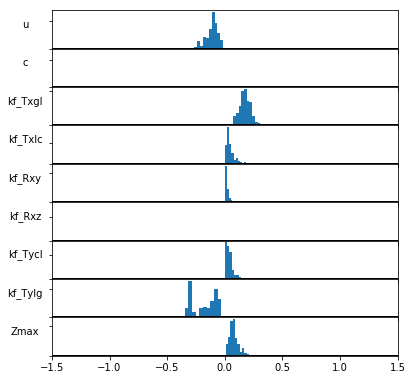

In [31]:
sens_Yl.hist(xlims=[[-1.5,1.5]]*9, figsize=(6,6))

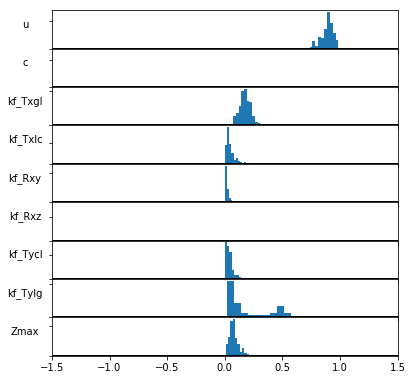

In [32]:
sens_JTyout.hist(xlims=[[-1.5,1.5]]*9, figsize=(6,6))